# Lambda School Data Science - Recurrent Neural Networks and LSTM

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

# Lecture

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

## Time series with plain old regression

Recurrences are fancy, and we'll get to those later - let's start with something simple. Regression can handle time series just fine if you just set them up correctly - let's try some made-up stock data. And to make it, let's use a few list comprehensions!

In [1]:
import numpy as np
from random import random
days = np.array((range(28)))
stock_quotes = np.array([random() + day * random() for day in days])

In [2]:
stock_quotes

array([ 0.68087513,  1.1534174 ,  0.41458821,  0.89047739,  2.55203896,
        3.42615812,  4.05268708,  2.18174666,  5.649702  ,  1.26254507,
        9.99845917, 11.69787182,  5.74947931,  8.10957471, 11.62326892,
        7.4590799 , 10.87827232,  5.1273977 ,  4.18948739,  9.1880204 ,
       16.11350296,  6.23742041, 17.92242301,  7.14378024, 14.35057223,
       10.06368816,  9.65745329, 24.98120863])

Let's take a look with a scatter plot:

In [3]:
from matplotlib.pyplot import scatter
scatter(days, stock_quotes)

Looks pretty linear, let's try a simple OLS regression.

First, these need to be NumPy arrays:

In [4]:
days = days.reshape(-1, 1)  # X needs to be column vectors

Now let's use good old `scikit-learn` and linear regression:

In [5]:
from sklearn.linear_model import LinearRegression
ols_stocks = LinearRegression()
ols_stocks.fit(days, stock_quotes)
ols_stocks.score(days, stock_quotes)

0.5648321037888444

That seems to work pretty well, but real stocks don't work like this.

Let's make *slightly* more realistic data that depends on more than just time:

In [6]:
# Not everything is best as a comprehension
stock_data = np.empty([len(days), 4])
for day in days:
  asset = random()
  liability = random()
  quote = random() + ((day * random()) + (20 * asset) - (15 * liability))
  quote = max(quote, 0.01)  # Want positive quotes
  stock_data[day] = np.array([quote, day, asset, liability])

In [7]:
stock_data

array([[2.02360891e+00, 0.00000000e+00, 2.40482538e-01, 2.14049958e-01],
       [7.24780084e+00, 1.00000000e+00, 8.34617460e-01, 6.86157208e-01],
       [7.97903071e+00, 2.00000000e+00, 8.85155762e-01, 6.53450363e-01],
       [1.00000000e-02, 3.00000000e+00, 2.27261032e-02, 4.49404088e-01],
       [7.49294859e-01, 4.00000000e+00, 6.03139147e-01, 8.82431763e-01],
       [3.21633727e-01, 5.00000000e+00, 3.68922459e-01, 8.16589562e-01],
       [5.63067542e+00, 6.00000000e+00, 7.31596118e-01, 7.31179716e-01],
       [9.19460764e+00, 7.00000000e+00, 4.78703735e-01, 2.35183073e-01],
       [1.97363569e+01, 8.00000000e+00, 7.16504012e-01, 5.37649541e-02],
       [9.25887791e+00, 9.00000000e+00, 7.03094667e-01, 5.12154007e-01],
       [2.72287196e+00, 1.00000000e+01, 2.58391766e-01, 6.62711916e-01],
       [4.63406476e+00, 1.10000000e+01, 6.31258189e-01, 6.29264847e-01],
       [1.13734430e+00, 1.20000000e+01, 2.11213477e-01, 3.45118981e-01],
       [1.65055550e+01, 1.30000000e+01, 2.55715966e

Let's look again:

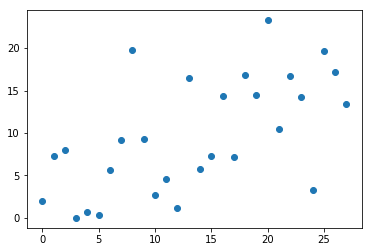

In [8]:
stock_quotes = stock_data[:,0]
scatter(days, stock_quotes)

How does our old model do?

In [9]:
days = np.array(days).reshape(-1, 1)
ols_stocks.fit(days, stock_quotes)
ols_stocks.score(days, stock_quotes)

0.35389708513116847

Not bad, but can we do better?

In [10]:
ols_stocks.fit(stock_data[:,1:], stock_quotes)
ols_stocks.score(stock_data[:,1:], stock_quotes)

0.7900931186041331

Yep - unsurprisingly, the other covariates (assets and liabilities) have info.

But, they do worse without the day data.

In [11]:
ols_stocks.fit(stock_data[:,2:], stock_quotes)
ols_stocks.score(stock_data[:,2:], stock_quotes)

0.5384959549958062

## Time series jargon

There's a lot of semi-standard language and tricks to talk about this sort of data. [NIST](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm) has an excellent guidebook, but here are some highlights:

### Moving average

Moving average aka rolling average aka running average.

Convert a series of data to a series of averages of continguous subsets:

In [12]:
stock_quotes_rolling = [sum(stock_quotes[i:i+3]) / 3
                        for i in range(len(stock_quotes - 2))]
stock_quotes_rolling

[5.75014681815041,
 5.078943848145822,
 2.912775188960339,
 0.360309528873861,
 2.2338680014788466,
 5.048972262050504,
 11.520546646947755,
 12.729947477811931,
 10.572702250126909,
 5.538604874674051,
 2.831427003506865,
 7.425654670389723,
 7.807575287352765,
 9.865584788969343,
 9.153825116525844,
 9.617322836510674,
 12.796077820368835,
 12.850334002341365,
 18.21554692835468,
 16.08695167642661,
 16.8251565513686,
 13.813605441746391,
 11.428065790893925,
 12.416808827942505,
 13.396133193265877,
 16.766749826352825,
 10.195453752014727,
 4.472360981416462]

Pandas has nice series related functions:

In [13]:
import pandas as pd
df = pd.DataFrame(stock_quotes)
df.rolling(3).mean()

,0
0,NaN
1,NaN
2,5.750147
3,5.078944
4,2.912775
5,0.360310
6,2.233868
7,5.048972
8,11.520547
9,12.729947


### Forecasting

Forecasting - at it's simplest, it just means "predict the future":

In [14]:
ols_stocks.fit(stock_data[:,1:], stock_quotes)
ols_stocks.predict([[29, 0.5, 0.5]])

array([15.39498648])

One way to predict if you just have the series data is to use the prior observation. This can be pretty good (if you had to pick one feature to model the temperature for tomorrow, the temperature today is a good choice).

In [15]:
temperature = np.array([30 + random() * day
                        for day in np.array(range(365)).reshape(-1, 1)])
temperature_next = temperature[1:].reshape(-1, 1)
temperature_ols = LinearRegression()
temperature_ols.fit(temperature[:-1], temperature_next)
temperature_ols.score(temperature[:-1], temperature_next)

0.17704471020284496

But you can often make it better by considering more than one prior observation.

In [16]:
temperature_next_next = temperature[2:].reshape(-1, 1)
temperature_two_past = np.concatenate([temperature[:-2], temperature_next[:-1]],
                                      axis=1)
temperature_ols.fit(temperature_two_past, temperature_next_next)
temperature_ols.score(temperature_two_past, temperature_next_next)

0.24474056347790565

### Exponential smoothing

Exponential smoothing means using exponentially decreasing past weights to predict the future.

You could roll your own, but let's use Pandas.

In [17]:
temperature_df = pd.DataFrame(temperature)
temperature_df.ewm(halflife=7).mean()

,0
0,30.000000
1,30.238878
2,30.447663
3,30.472670
4,30.576881
5,31.437000
6,31.331685
7,31.891170
8,32.737660
9,33.004512


Halflife is among the parameters we can play with:

In [18]:
sse_1 = ((temperature_df - temperature_df.ewm(halflife=7).mean())**2).sum()
sse_2 = ((temperature_df - temperature_df.ewm(halflife=3).mean())**2).sum()
print(sse_1)
print(sse_2)

0    1.165527e+06
dtype: float64
0    942543.732255
dtype: float64


Note - the first error being higher doesn't mean it's necessarily *worse*. It's *smoother* as expected, and if that's what we care about - great!

### Seasonality

Seasonality - "day of week"-effects, and more. In a lot of real world data, certain time periods are systemically different, e.g. holidays for retailers, weekends for restaurants, seasons for weather.

Let's try to make some seasonal data - a store that sells more later in a week:

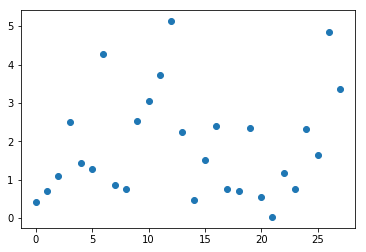

In [19]:
sales = np.array([random() + (day % 7) * random() for day in days])
scatter(days, sales)

How does linear regression do at fitting this?

In [20]:
sales_ols = LinearRegression()
sales_ols.fit(days, sales)
sales_ols.score(days, sales)

0.0145042631748461

That's not great - and the fix depends on the domain. Here, we know it'd be best to actually use "day of week" as a feature.

In [21]:
day_of_week = days % 7
sales_ols.fit(day_of_week, sales)
sales_ols.score(day_of_week, sales)

0.35310387902436735

Note that it's also important to have representative data across whatever seasonal feature(s) you use - don't predict retailers based only on Christmas, as that won't generalize well.

## Recurrent Neural Networks

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

### RNN/LSTM Sentiment Classification with Keras

In [22]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

/home/rick1270/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train...
Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 96s 4ms/step - loss: 0.4574 - acc: 0.7831 - val_loss: 0.3937 - val_acc: 0.8252
Epoch 2/5
25000/25000 [==============================] - 92s 4ms/step - loss: 0.3079 - acc: 0.8750 - val_loss: 0.3805 - val_acc: 0.8321
Epoch 3/5
25000/25000 [==============================] - 93s 4ms/step - loss: 0.2208 - acc: 0.9151 - val_loss: 0.4259 - val_acc: 0.8302
Epoch 4/5
25000/25000 [==============================] - 93s 4ms/step - loss: 0.1604 - acc: 0.9402 - val_loss: 0.4663 - val_acc: 0.8298
Epoc

### RNN Text generation with NumPy

What else can we do with RNN? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. We'll pull some news stories using [newspaper](https://github.com/codelucas/newspaper/).

#### Initialization

In [23]:
!pip install newspaper3k

    100% |████████████████████████████████| 215kB 10.6MB/s ta 0:00:01
    100% |████████████████████████████████| 194kB 12.5MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 13.6MB/s ta 0:00:01
    100% |████████████████████████████████| 7.4MB 3.7MB/s eta 0:00:01
  Stored in directory: /home/rick1270/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Stored in directory: /home/rick1270/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
  Stored in directory: /home/rick1270/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Stored in directory: /home/rick1270/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
Successfully built feedfinder2 feedparser tinysegmenter jieba3k


In [24]:
import newspaper

In [25]:
ap = newspaper.build('https://www.apnews.com')
len(ap.articles)

64

In [26]:
article_text = ''

for article in ap.articles[:1]:
  try:
    article.download()
    article.parse()
    article_text += '\n\n' + article.text
  except:
    print('Failed: ' + article.url)
  
article_text = article_text.split('\n\n')[1]
print(article_text)

Legalization of medical and recreational marijuana in many states has created a salary boom for the executives behind the business and commerce of the emerging field.


In [27]:
# Based on "The Unreasonable Effectiveness of RNN" implementation
import numpy as np

chars = list(set(article_text)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
txt_data_size = len(article_text)

print("unique characters : ", num_chars)
print("txt_data_size : ", txt_data_size)

unique characters :  25
txt_data_size :  166


In [28]:
# one hot encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
integer_encoded = [char_to_int[i] for i in article_text] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

{'c': 0, '.': 1, 'n': 2, 'm': 3, 'l': 4, 'j': 5, 'g': 6, 'a': 7, 'v': 8, 'y': 9, 'e': 10, 'f': 11, 's': 12, 'i': 13, 't': 14, ' ': 15, 'u': 16, 'z': 17, 'd': 18, 'b': 19, 'r': 20, 'o': 21, 'h': 22, 'L': 23, 'x': 24}
----------------------------------------------------
{0: 'c', 1: '.', 2: 'n', 3: 'm', 4: 'l', 5: 'j', 6: 'g', 7: 'a', 8: 'v', 9: 'y', 10: 'e', 11: 'f', 12: 's', 13: 'i', 14: 't', 15: ' ', 16: 'u', 17: 'z', 18: 'd', 19: 'b', 20: 'r', 21: 'o', 22: 'h', 23: 'L', 24: 'x'}
----------------------------------------------------
[23, 10, 6, 7, 4, 13, 17, 7, 14, 13, 21, 2, 15, 21, 11, 15, 3, 10, 18, 13, 0, 7, 4, 15, 7, 2, 18, 15, 20, 10, 0, 20, 10, 7, 14, 13, 21, 2, 7, 4, 15, 3, 7, 20, 13, 5, 16, 7, 2, 7, 15, 13, 2, 15, 3, 7, 2, 9, 15, 12, 14, 7, 14, 10, 12, 15, 22, 7, 12, 15, 0, 20, 10, 7, 14, 10, 18, 15, 7, 15, 12, 7, 4, 7, 20, 9, 15, 19, 21, 21, 3, 15, 11, 21, 20, 15, 14, 22, 10, 15, 10, 24, 10, 0, 16, 14, 13, 8, 10, 12, 15, 19, 10, 22, 13, 2, 18, 15, 14, 22, 10, 15, 19, 16, 12, 1

In [29]:
# hyperparameters

iteration = 1000
sequence_length = 40
batch_size = round((txt_data_size /sequence_length)+0.5) # = math.ceil
hidden_size = 500  # size of hidden layer of neurons.  
learning_rate = 1e-1


# model parameters

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)

#### Forward propagation

In [30]:
def forwardprop(inputs, targets, h_prev):
        
    # Since the RNN receives the sequence, the weights are not updated during one sequence.
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    hs[-1] = np.copy(h_prev) # Copy previous hidden state vector to -1 key value.
    loss = 0 # loss initialization
    
    for t in range(len(inputs)): # t is a "time step" and is used as a key(dic).  
        
        xs[t] = np.zeros((num_chars,1)) 
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) # hidden state. 
        ys[t] = np.dot(W_hy, hs[t]) + b_y # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars. 
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, but all of the elements are positive through the exp() function.
 
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss). Efficient and simple code

#         y_class = np.zeros((num_chars, 1)) 
#         y_class[targets[t]] =1
#         loss += np.sum(y_class*(-np.log(ps[t]))) # softmax (cross-entropy loss)        

    return loss, ps, hs, xs

#### Backward propagation

In [31]:
def backprop(ps, inputs, hs, xs):

    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) # make all zero matrices.
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        dy[targets[t]] -= 1 # backprop into y. After taking the soft max in the input vector, subtract 1 from the value of the element corresponding to the correct label.
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby

#### Training

In [32]:
%%time

data_pointer = 0

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 

for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size):
        
        inputs = [char_to_int[ch] for ch in article_text[data_pointer:data_pointer+sequence_length]]
        targets = [char_to_int[ch] for ch in article_text[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
            
        if (data_pointer+sequence_length+1 >= len(article_text) and b == batch_size-1): # processing of the last part of the input data. 
#             targets.append(char_to_int[txt_data[0]])   # When the data doesn't fit, add the first char to the back.
            targets.append(char_to_int[" "])   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
#         print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer
        
    if i % 100 == 0:
        print ('iter %d, loss: %f' % (i, loss)) # print progress

iter 0, loss: 161.441863
iter 100, loss: 0.057250
iter 200, loss: 0.051875
iter 300, loss: 0.055354
iter 400, loss: 0.486259
iter 500, loss: 0.264506
iter 600, loss: 0.158980
iter 700, loss: 0.092341
iter 800, loss: 0.089588
iter 900, loss: 0.109616
CPU times: user 4min 12s, sys: 1.94 s, total: 4min 14s
Wall time: 1min 3s


#### Prediction

In [35]:
def predict(test_char, length):
    x = np.zeros((num_chars, 1)) 
    x[char_to_int[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(W_xh, x) + np.dot(W_hh, h) + b_h) 
        y = np.dot(W_hy, h) + b_y
        p = np.exp(y) / np.sum(np.exp(y)) 
        ix = np.random.choice(range(num_chars), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((num_chars, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
    txt = test_char + ''.join(int_to_char[i] for i in ixes)
    print ('----\n %s \n----' % (txt, ))

In [37]:
predict('b', 50)

----
 besar ed brtssing  ofd cesa etes hacecutasthrmatecd 
----


Well... that's *vaguely* language-looking. Can you do better?

# Assignment

![Monkey at a typewriter](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Chimpanzee_seated_at_typewriter.jpg/603px-Chimpanzee_seated_at_typewriter.jpg)

It is said that [infinite monkeys typing for an infinite amount of time](https://en.wikipedia.org/wiki/Infinite_monkey_theorem) will eventually type, among other things, the complete works of Wiliam Shakespeare. Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the complete works of Shakespeare: https://www.gutenberg.org/files/100/100-0.txt

Use it as training data for an RNN - you can keep it simple and train character level, and that is suggested as an initial approach.

Then, use that trained RNN to generate Shakespearean-ish text. Your goal - a function that can take, as an argument, the size of text (e.g. number of characters or lines) to generate, and returns generated text of that size.

Note - Shakespeare wrote an awful lot. It's OK, especially initially, to sample/use smaller data and parameters, so you can have a tighter feedback loop when you're trying to get things running. Then, once you've got a proof of concept - start pushing it more!

In [162]:
import requests
import numpy as np
r = requests.get('https://www.gutenberg.org/files/100/100-0.txt')

In [182]:
complete_works = r.text[3000:]
complete_works = complete_works[:5000]

In [183]:
chars = list(set(complete_works)) # split and remove duplicate characters. convert to list.
num_chars = len(chars)
txt_data_size = len(complete_works)

print("unique characters : ", num_chars)
print("txt_data_size : ", txt_data_size)
print('All characters: \n', [x for x in chars])

unique characters :  65
txt_data_size :  5000
All characters: 
 ['S', '8', 'D', 'c', 'w', '.', 'n', 'm', 'L', ')', '\r', 'P', '5', '(', 'l', '2', '6', 'j', 'T', 'a', 'g', 'v', ';', 'R', 'y', 'F', 'B', '‘', 'e', 'f', 's', 'U', 'H', '-', 'i', 'A', '4', '3', 't', 'N', ' ', 'u', 'z', 'C', 'd', 'k', ',', 'r', 'b', 'Y', 'M', 'I', 'O', 'o', ':', '\n', 'W', '’', '?', 'h', '7', 'p', '1', 'q', 'x']


In [184]:
# integer-encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
        

{'S': 0, '8': 1, 'D': 2, 'c': 3, 'w': 4, '.': 5, 'n': 6, 'm': 7, 'L': 8, ')': 9, '\r': 10, 'P': 11, '5': 12, '(': 13, 'l': 14, '2': 15, '6': 16, 'j': 17, 'T': 18, 'a': 19, 'g': 20, 'v': 21, ';': 22, 'R': 23, 'y': 24, 'F': 25, 'B': 26, '‘': 27, 'e': 28, 'f': 29, 's': 30, 'U': 31, 'H': 32, '-': 33, 'i': 34, 'A': 35, '4': 36, '3': 37, 't': 38, 'N': 39, ' ': 40, 'u': 41, 'z': 42, 'C': 43, 'd': 44, 'k': 45, ',': 46, 'r': 47, 'b': 48, 'Y': 49, 'M': 50, 'I': 51, 'O': 52, 'o': 53, ':': 54, '\n': 55, 'W': 56, '’': 57, '?': 58, 'h': 59, '7': 60, 'p': 61, '1': 62, 'q': 63, 'x': 64}
----------------------------------------------------
{0: 'S', 1: '8', 2: 'D', 3: 'c', 4: 'w', 5: '.', 6: 'n', 7: 'm', 8: 'L', 9: ')', 10: '\r', 11: 'P', 12: '5', 13: '(', 14: 'l', 15: '2', 16: '6', 17: 'j', 18: 'T', 19: 'a', 20: 'g', 21: 'v', 22: ';', 23: 'R', 24: 'y', 25: 'F', 26: 'B', 27: '‘', 28: 'e', 29: 'f', 30: 's', 31: 'U', 32: 'H', 33: '-', 34: 'i', 35: 'A', 36: '4', 37: '3', 38: 't', 39: 'N', 40: ' ', 41: 'u',

In [185]:
# integer-encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")

{'S': 0, '8': 1, 'D': 2, 'c': 3, 'w': 4, '.': 5, 'n': 6, 'm': 7, 'L': 8, ')': 9, '\r': 10, 'P': 11, '5': 12, '(': 13, 'l': 14, '2': 15, '6': 16, 'j': 17, 'T': 18, 'a': 19, 'g': 20, 'v': 21, ';': 22, 'R': 23, 'y': 24, 'F': 25, 'B': 26, '‘': 27, 'e': 28, 'f': 29, 's': 30, 'U': 31, 'H': 32, '-': 33, 'i': 34, 'A': 35, '4': 36, '3': 37, 't': 38, 'N': 39, ' ': 40, 'u': 41, 'z': 42, 'C': 43, 'd': 44, 'k': 45, ',': 46, 'r': 47, 'b': 48, 'Y': 49, 'M': 50, 'I': 51, 'O': 52, 'o': 53, ':': 54, '\n': 55, 'W': 56, '’': 57, '?': 58, 'h': 59, '7': 60, 'p': 61, '1': 62, 'q': 63, 'x': 64}
----------------------------------------------------
{0: 'S', 1: '8', 2: 'D', 3: 'c', 4: 'w', 5: '.', 6: 'n', 7: 'm', 8: 'L', 9: ')', 10: '\r', 11: 'P', 12: '5', 13: '(', 14: 'l', 15: '2', 16: '6', 17: 'j', 18: 'T', 19: 'a', 20: 'g', 21: 'v', 22: ';', 23: 'R', 24: 'y', 25: 'F', 26: 'B', 27: '‘', 28: 'e', 29: 'f', 30: 's', 31: 'U', 32: 'H', 33: '-', 34: 'i', 35: 'A', 36: '4', 37: '3', 38: 't', 39: 'N', 40: ' ', 41: 'u',

In [186]:
# hyperparameters

iteration = 1000
sequence_length = 30
batch_size = round((txt_data_size /sequence_length)+0.5) # = math.ceil
hidden_size = 100  # size of hidden layer of neurons.  
learning_rate = 1e-1


# model parameters

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)


In [187]:
def forwardprop(inputs, targets, h_prev):
        
    # Since the RNN receives the sequence, the weights are not updated during one sequence.
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    hs[-1] = np.copy(h_prev) # Copy previous hidden state vector to -1 key value.
    loss = 0 # loss initialization
    
    for t in range(len(inputs)): # t is a "time step" and is used as a key(dic).  
        
        xs[t] = np.zeros((num_chars,1)) 
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) # hidden state. 
        ys[t] = np.dot(W_hy, hs[t]) + b_y # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars. 
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, but all of the elements are positive through the exp() function.
 
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss). Efficient and simple code

#         y_class = np.zeros((num_chars, 1)) 
#         y_class[targets[t]] =1
#         loss += np.sum(y_class*(-np.log(ps[t]))) # softmax (cross-entropy loss)        

    return loss, ps, hs, xs

In [188]:
def backprop(ps, inputs, hs, xs):

    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) # make all zero matrices.
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        dy[targets[t]] -= 1 # backprop into y. After taking the soft max in the input vector, subtract 1 from the value of the element corresponding to the correct label.
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby

In [189]:
%%time

data_pointer = 0

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 

for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size):
        
        inputs = [char_to_int[ch] for ch in article_text[data_pointer:data_pointer+sequence_length]]
        targets = [char_to_int[ch] for ch in article_text[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
            
        if (data_pointer+sequence_length+1 >= len(article_text) and b == batch_size-1): # processing of the last part of the input data. 
#             targets.append(char_to_int[txt_data[0]])   # When the data doesn't fit, add the first char to the back.
            targets.append(char_to_int[" "])   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
#         print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer
        
    if i % 1 == 0:
        print ('iter %d, loss: %f' % (i, loss)) # print progress

iter 0, loss: 59.161897
iter 1, loss: 56.745057
iter 2, loss: 55.301505
iter 3, loss: 52.809702
iter 4, loss: 51.606420
iter 5, loss: 50.487239
iter 6, loss: 49.587648
iter 7, loss: 47.958909
iter 8, loss: 47.337712
iter 9, loss: 47.172168
iter 10, loss: 45.446517
iter 11, loss: 45.612018
iter 12, loss: 44.798459
iter 13, loss: 44.970948
iter 14, loss: 45.285611
iter 15, loss: 46.013653
iter 16, loss: 46.647966
iter 17, loss: 46.242258
iter 18, loss: 46.350650
iter 19, loss: 45.733566
iter 20, loss: 46.063358
iter 21, loss: 45.269677
iter 22, loss: 44.756551
iter 23, loss: 44.996938
iter 24, loss: 45.582398
iter 25, loss: 44.362019
iter 26, loss: 43.528994
iter 27, loss: 44.148611
iter 28, loss: 44.486467
iter 29, loss: 43.472553
iter 30, loss: 42.783628
iter 31, loss: 41.322550
iter 32, loss: 42.376688
iter 33, loss: 42.349413
iter 34, loss: 41.837375
iter 35, loss: 42.449625
iter 36, loss: 42.690173
iter 37, loss: 42.899029
iter 38, loss: 41.477270
iter 39, loss: 41.744924
iter 40, l

iter 320, loss: 14.661318
iter 321, loss: 13.897483
iter 322, loss: 13.833375
iter 323, loss: 13.400749
iter 324, loss: 13.524528
iter 325, loss: 14.219955
iter 326, loss: 15.594389
iter 327, loss: 14.082550
iter 328, loss: 14.467119
iter 329, loss: 17.006236
iter 330, loss: 13.806817
iter 331, loss: 12.778574
iter 332, loss: 17.327594
iter 333, loss: 13.212841
iter 334, loss: 11.894521
iter 335, loss: 13.247647
iter 336, loss: 12.589505
iter 337, loss: 12.896384
iter 338, loss: 14.024049
iter 339, loss: 13.248228
iter 340, loss: 13.148388
iter 341, loss: 11.933981
iter 342, loss: 13.079229
iter 343, loss: 11.536051
iter 344, loss: 14.570970
iter 345, loss: 15.375939
iter 346, loss: 13.182532
iter 347, loss: 12.216068
iter 348, loss: 12.097745
iter 349, loss: 14.268345
iter 350, loss: 12.631988
iter 351, loss: 11.788750
iter 352, loss: 14.281572
iter 353, loss: 12.764488
iter 354, loss: 12.104754
iter 355, loss: 12.755665
iter 356, loss: 14.536862
iter 357, loss: 13.571691
iter 358, lo

iter 641, loss: 7.365379
iter 642, loss: 16.774302
iter 643, loss: 17.397522
iter 644, loss: 8.858470
iter 645, loss: 9.355322
iter 646, loss: 8.978283
iter 647, loss: 8.600740
iter 648, loss: 9.260005
iter 649, loss: 7.151229
iter 650, loss: 13.479922
iter 651, loss: 7.625723
iter 652, loss: 7.399069
iter 653, loss: 9.360474
iter 654, loss: 8.090150
iter 655, loss: 7.599677
iter 656, loss: 7.098414
iter 657, loss: 9.835537
iter 658, loss: 7.538204
iter 659, loss: 9.538663
iter 660, loss: 8.135463
iter 661, loss: 8.108956
iter 662, loss: 8.225927
iter 663, loss: 9.269677
iter 664, loss: 8.095514
iter 665, loss: 7.449095
iter 666, loss: 7.011725
iter 667, loss: 8.422992
iter 668, loss: 6.860909
iter 669, loss: 8.217687
iter 670, loss: 9.806477
iter 671, loss: 7.263207
iter 672, loss: 10.565483
iter 673, loss: 8.182514
iter 674, loss: 7.857902
iter 675, loss: 7.064124
iter 676, loss: 8.569531
iter 677, loss: 7.964050
iter 678, loss: 7.085370
iter 679, loss: 8.958336
iter 680, loss: 9.654

iter 967, loss: 7.488124
iter 968, loss: 7.170083
iter 969, loss: 7.226299
iter 970, loss: 13.345011
iter 971, loss: 9.667065
iter 972, loss: 17.182253
iter 973, loss: 9.855784
iter 974, loss: 7.810931
iter 975, loss: 7.219388
iter 976, loss: 7.982136
iter 977, loss: 7.484552
iter 978, loss: 7.607604
iter 979, loss: 7.646256
iter 980, loss: 7.093352
iter 981, loss: 7.514625
iter 982, loss: 7.009198
iter 983, loss: 7.056584
iter 984, loss: 7.259424
iter 985, loss: 6.932261
iter 986, loss: 9.772591
iter 987, loss: 7.643215
iter 988, loss: 8.755634
iter 989, loss: 9.357314
iter 990, loss: 6.501394
iter 991, loss: 7.672979
iter 992, loss: 7.273746
iter 993, loss: 6.749523
iter 994, loss: 7.538495
iter 995, loss: 8.176121
iter 996, loss: 7.035859
iter 997, loss: 13.102949
iter 998, loss: 8.277997
iter 999, loss: 7.039740
CPU times: user 30min 11s, sys: 7.84 s, total: 30min 19s
Wall time: 7min 34s


In [190]:

def predict(test_char, length):
    x = np.zeros((num_chars, 1)) 
    x[char_to_int[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(W_xh, x) + np.dot(W_hh, h) + b_h) 
        y = np.dot(W_hy, h) + b_y
        p = np.exp(y) / np.sum(np.exp(y)) 
        ix = np.random.choice(range(num_chars), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((num_chars, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
    txt = test_char + ''.join(int_to_char[i] for i in ixes)
    print ('----\n %s \n----' % (txt, ))

In [192]:
predict('Y', 1000)


----
 Yet nklbsedith whe hranth semend,
Bew reod  4
Frre wores ris the to geves of ther:
Make nose of murle,
Bet riven warksshe lives the arngle wies of tro so lafty lappies of tinglendem:

Unthre,
In shoulsshis nou pover ntine ambeauty’s qoct ber es thine heinthrefrme foonest an thath shoof ile,
If ary dest,
A glave?
   t shoud dap it nou gaivive?
Bus joy:
  Pity tant bequest nou le dis thy ford fariny saling wsers with swaad, his med:
Then thy loous rich-th meature fais bein nel:
Makpay the ind to b’s now one ressthrit bar’shat sim mor,
Thy fee love, tyouert sorld, the ve aro-serer meveno shathely lladeaved not thee,
Lipes ro fraff the lovert happier,
Bean withigg red,
In sith givich happie fooksery siglade usuty ins,
Werd dee,
B wor shene stemee dert with frost and thou steldaAnd whind of sumoms lached thee horedat,
Athes refted thy tor livisg wse ton time.
How or the ic nfole,
Thee tamcith hadong tillert lrondhighmostitlf fimese aine.

 e tid cow,
Food:
  Thine  
----


# Resources and Stretch Goals

## Stretch goals:
- Refine the training and generation of text to be able to ask for different genres/styles of Shakespearean text (e.g. plays versus sonnets)
- Train a classification model that takes text and returns which work of Shakespeare it is most likely to be from
- Make it more performant! Many possible routes here - lean on Keras, optimize the code, and/or use more resources (AWS, etc.)
- Revisit the news example from class, and improve it - use categories or tags to refine the model/generation, or train a news classifier
- Run on bigger, better data

## Resources:
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) - a seminal writeup demonstrating a simple but effective character-level NLP RNN
- [Simple NumPy implementation of RNN](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb) - Python 3 version of the code from "Unreasonable Effectiveness"
- [TensorFlow RNN Tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn) - code for training a RNN on the Penn Tree Bank language dataset
- [4 part tutorial on RNN](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) - relates RNN to the vanishing gradient problem, and provides example implementation
- [RNN training tips and tricks](https://github.com/karpathy/char-rnn#tips-and-tricks) - some rules of thumb for parameterizing and training your RNN